In [46]:
## Version 2 Backtesting Engine
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

plt.style.use('ggplot')

print("Libraries loaded.")

Libraries loaded.


In [47]:
import pandas as pd

# load csv file
prices_df = pd.read_csv('portfolio_data.csv', index_col='Date', parse_dates=True)

# check it loaded correctly
print(prices_df.head())

              AAPL     JNJ     JPM   NVDA    TSLA
Date                                             
2021-01-06  123.24  138.67  116.37  12.58  251.99
2021-01-07  127.44  139.14  120.19  13.31  272.01
2021-01-08  128.54  138.85  120.32  13.24  293.34
2021-01-11  125.56  138.27  122.12  13.58  270.40
2021-01-12  125.38  137.19  124.04  13.45  283.15


In [48]:
import cvxpy as cp
import pandas as pd
import numpy as np

def solve_portfolio(mu, tickers, tech_indices=None, max_weight=0.25, tech_cap=0.35): #add constraints as we need
    """
    Solves a Linear Programming portfolio optimization problem.
    
    Args:
        mu (pd.Series or np.array): Expected returns for each asset.
        tickers (list): List of ticker symbols corresponding to mu.
        tech_indices (list, optional): Indices of tech stocks for sector capping.
        max_weight (float): Maximum weight allowed for a single asset (default 0.25).
        tech_cap (float): Maximum total weight for the tech sector (default 0.35).
        
    Returns:
        pd.Series: Optimal weights for the portfolio.
    """
    
    # Decision Variables
    n_assets = len(tickers)
    w = cp.Variable(n_assets)

    # Obj Func
    # Maximize total return: sum(weight * expected_return)
    objective = cp.Maximize(mu @ w)

    # Constraints
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w <= max_weight  # Diversification Constraint
    ]
    
    # Optional: Add Sector Cap 
    #if tech_indices is not None:
        #constraints.append(cp.sum(w[tech_indices]) <= tech_cap)

    # Solve LP
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP)

    # Output Handling
    print("Optimization Status:", prob.status)
    print(f"Maximized Daily Return: {prob.value:.5f}")

    # Clean up weights
    optimal_weights = pd.Series(w.value, index=tickers).round(4)
    clean_weights = optimal_weights[optimal_weights > 0.001] # Filter small dust


    # Dynamic Shadow Price Analysis
    # The 'max_weight' constraint is at index 25 in our list
    # The dual_value is an array matching the number of assets
    if prob.status == 'optimal':
        print(f"\n--- Shadow Price Analysis (Max Weight: {max_weight*100}%) ---")
        shadow_prices = constraints[2].dual_value 
        
        found_binding = False
        for i, price in enumerate(shadow_prices):
            # If shadow price is significant, that constraint is binding
            if price > 0.0001:
                found_binding = True
                print(f"Constraint Binding on {tickers[i]}! Shadow Price: {price:.5f}")
        
        if not found_binding:
            print("No single asset hit the weight limit.")

    return clean_weights

Strategy defined.


Data Shape: (1255, 5)
--- Starting Backtest (Lookback: 60 days) ---
--- Expected Returns (mu) ---
JPM     0.002747
NVDA    0.002010
JNJ     0.000481
AAPL   -0.000258
TSLA   -0.001192
dtype: float64
Optimization Status: optimal
Maximized Daily Return: 0.00125

--- Shadow Price Analysis (Max Weight: 25.0%) ---
Constraint Binding on JNJ! Shadow Price: 0.00077
Constraint Binding on JPM! Shadow Price: 0.00304
Constraint Binding on NVDA! Shadow Price: 0.00230

--- Rebalance on 2021-04-05 ---
  AAPL: 25.0%
  JNJ: 25.0%
  JPM: 25.0%
  NVDA: 25.0%
[2021-04-05] Rebalance: Funds $100,000
--- Expected Returns (mu) ---
NVDA    0.002075
JPM     0.001995
JNJ     0.000227
AAPL   -0.000565
TSLA   -0.002087
dtype: float64
Optimization Status: optimal
Maximized Daily Return: 0.00093

--- Shadow Price Analysis (Max Weight: 25.0%) ---
Constraint Binding on AAPL! Shadow Price: 0.00017
Constraint Binding on JNJ! Shadow Price: 0.00097
Constraint Binding on JPM! Shadow Price: 0.00273
Constraint Binding on NVDA

<Axes: >

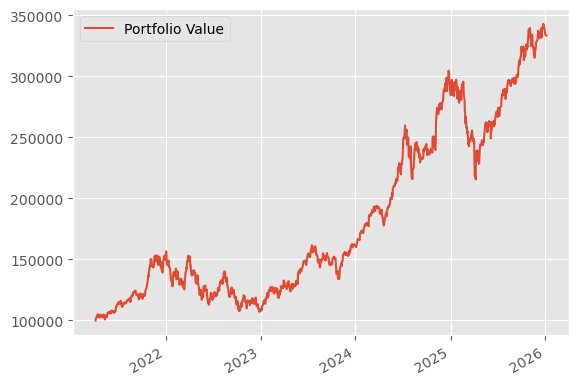

In [ ]:

import pandas as pd
import numpy as np
tickers = prices_df.columns.tolist()

def run_rolling_backtest(prices_df, lookback_days=60, rebalance_freq=20, initial_capital=100000):
    """
    Walks forward through time.
    At every rebalance step, looks at the PAST 'lookback_days' of prices.
    Calculates Expected Returns (mu) from that window. Note to self: (Will improve this by using better metric ex: sharpe ratio)
    Runs LP model to get optimal weights. 
    Tracks the portfolio value, prints portfolio status each rebalancing day.
    """
    
    
    
    # Uses a shift(-1) logic implicitly by trading at Close and realizing the NEXT day's return (YOU NEED TO REMEMBERRRR)
    # for simplicity here: If we hold weights on Day T, we apply them to returns on Day T+1 
    daily_returns_all = prices_df.pct_change().fillna(0)
    
    # setup
    portfolio_value = [initial_capital]
    current_weights = np.zeros(len(tickers))
    
    history_dates = []
    history_value = []
    start_index = lookback_days
    
    print(f"--- Starting Backtest (Lookback: {lookback_days} days) ---") # check lookback days is good


    # iterate through the integer indices of the DataFrame
    for t in range(start_index, len(prices_df)):
        
        today_date = prices_df.index[t]
        
        # CHECK IF REBALANCE DAY
        # rebalance if 't' aligns with our frequency (default 20)
        # start rebalancing immediately at start_index
        days_since_start = t - start_index
        
        if days_since_start % rebalance_freq == 0:
            try:
                # rolling Window (Past 60 days up to today)
                # slice from (t - lookback) to t
                price_window = prices_df.iloc[t-lookback_days : t]
                
                # calculate Expected Returns (mu) for THIS window
                # simple Mean Return Method
                mu_series = price_window.pct_change().dropna().mean()

                print("--- Expected Returns (mu) ---")
                print(mu_series.sort_values(ascending=False)) # Sort to see expected return ranking
                
                # optimize
                # pass this window's mu to LP solver
                new_weights_series = solve_portfolio(
    mu=mu_series.values,         # <--- Pass raw numpy array (NEED TO SINCE IT NO LIKE ANYTHING ELSE, BREAKS IF I USE ANYTHING ELSE)
    tickers=tickers,             # <--- Keep as the list of stock names   
    tech_indices=None            # <--- Force this to None 
)
                print(f"\n--- Rebalance on {today_date.date()} ---")
                # loop through the weights and print non-zero ones
                for ticker, weight in new_weights_series.items():
                    if weight > 0.001:  # Filter out 0.0 values (cleaner output)
                        print(f"  {ticker}: {weight * 100:.1f}%")
                # update Weights
                current_weights = new_weights_series.reindex(tickers).fillna(0).values
                
                print(f"[{today_date.date()}] Rebalance: Funds ${portfolio_value[-1]:,.0f}")
                
            except Exception as e:
                print(f"[{today_date.date()}] Optimization Failed: {e}")
                # Note: We keep holding previous weights if optimization fails
        
        # CALCULATE P&L FOR TOMORROWWW
        # apply the weights we hold TODAY to the market move occurring TOMORROW
        if t < len(prices_df) - 1:
            # Return of T+1
            next_day_return = daily_returns_all.iloc[t+1]
            
            # Portfolio Return = Weights * Stock Returns
            port_return = np.dot(current_weights, next_day_return)
            
            # Update Wealth
            new_val = portfolio_value[-1] * (1 + port_return)
            portfolio_value.append(new_val)
            
            history_dates.append(prices_df.index[t+1])
            history_value.append(new_val)

    # RESULTS YAYYYY
    results_df = pd.DataFrame({
        'Portfolio Value': history_value
    }, index=history_dates)
    
    print(f"--- Final Value: ${results_df['Portfolio Value'].iloc[-1]:,.2f} ---")
    return results_df

print("Data Shape:", prices_df.shape) #check dataframe
portfolio_performance = run_rolling_backtest(prices_df, lookback_days=60, rebalance_freq=20)
portfolio_performance.plot()

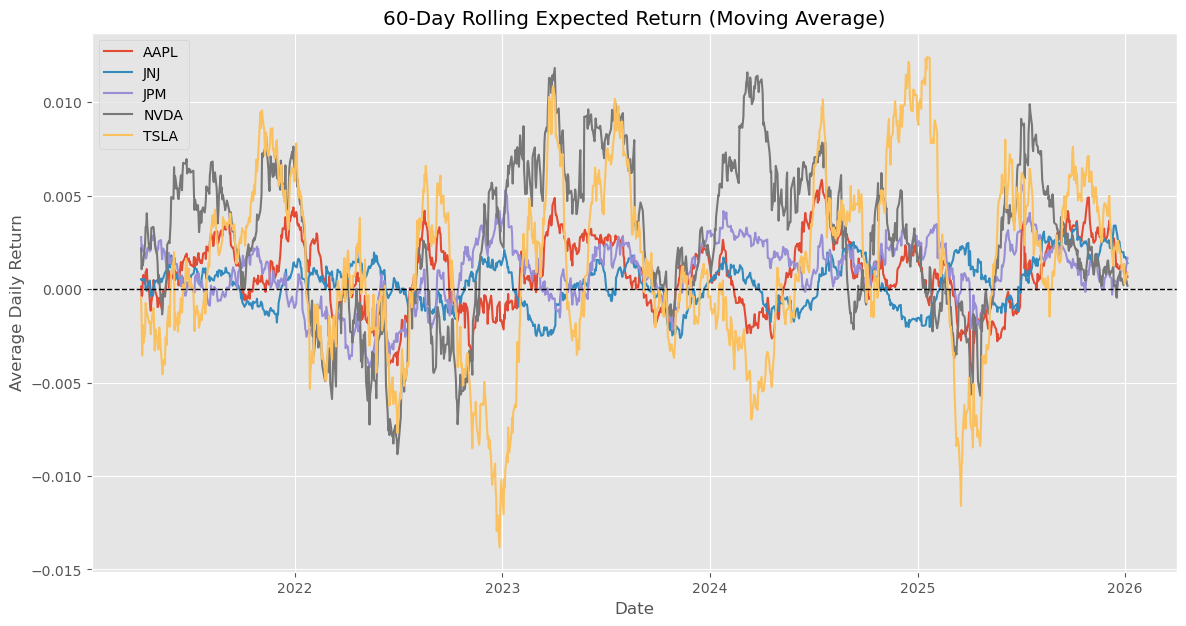

In [50]:
import matplotlib.pyplot as plt

def plot_rolling_returns(prices_df, lookback_days=60):
    # 1. Calculate Daily Returns
    daily_returns = prices_df.pct_change()
    
    # 2. Calculate Rolling Mean
    rolling_mu = daily_returns.rolling(window=lookback_days).mean()
    
    # 3. Plotting
    plt.figure(figsize=(14, 7))
    
    for stock in rolling_mu.columns:
        plt.plot(rolling_mu.index, rolling_mu[stock], label=stock)
    
    # FIXED LINE BELOW:
    plt.title(f'{lookback_days}-Day Rolling Expected Return (Moving Average)')
    plt.xlabel('Date')
    plt.ylabel('Average Daily Return')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.axhline(0, color='black', linewidth=1, linestyle='--')
    
    plt.show()

# --- Usage ---
plot_rolling_returns(prices_df, lookback_days=60)